# Library and Data Import

In [ ]:
# Import TensorFlow and test if GPU is detected
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# All other needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Read in Yelp, IMDB, Amazon data sets to Pandas DataFrames

yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None, names=['comment', 'rating'])

# IMDB file has many lines start with " which causes read_csv to skip the lines by default. Quoting=3 and quotechar=None appears to fix the behavior.
imdb = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, names=['comment', 'rating'], quotechar=None, quoting=3, skip_blank_lines=False)

amzn = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None, names=['comment', 'rating'])

# B1. Data Exploration

In [ ]:
yelp.info()
print(yelp.head())
print()
imdb.info()
print(imdb.head())
print()
amzn.info()
print(amzn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1000 non-null   object
 1   rating   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
                                             comment  rating
0                           Wow... Loved this place.       1
1                                 Crust is not good.       0
2          Not tasty and the texture was just nasty.       0
3  Stopped by during the late May bank holiday of...       1
4  The selection on the menu was great and so wer...       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1000 non-null   object
 1   rating   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
                         

In [ ]:
# Check for presence of non-ASCII characters
# Code ref: https://stackoverflow.com/a/18403812
def isascii(s):
    """
    Check if the characters in string s are in the ASCII region, U+0-U+FF.
    Unicode characters will be encoded as >1 byte
    """
    return len(s) == len(s.encode())


for c in (yelp[~yelp['comment'].apply(isascii)]['comment']):
    print(c)

print()

for c in (imdb[~imdb['comment'].apply(isascii)]['comment']):
    print(c)

print()

for c in (amzn[~amzn['comment'].apply(isascii)]['comment']):
    print(c)

print()

My fiancé and I came in the middle of the day and we were greeted and seated right away.
I really enjoyed Crema Café before they expanded; I even told friends they had the BEST breakfast.
The crêpe was delicate and thin and moist.
The only thing I wasn't too crazy about was their guacamole as I don't like it puréed.

It's practically perfect in all of them  a true masterpiece in a sea of faux "masterpieces.  
I'm glad this pretentious piece of s*** didn't do as planned by the Dodge stratus Big Shots... It's gonna help movie makers who aren't in the very restrained "movie business" of Québec.  
The script iswas there a script?  
I'll even say it again  this is torture.  
This show is made for Americans - it is too stupid and full with hatred and clichés to be admitted elsewhere.  
A cheap and cheerless heist movie with poor characterisation, lots of underbite style stoic emoting (think Chow Yun Fat in A Better Tomorrow) and some cheesy clichés thrown into an abandoned factory ready f

# B5. Data Preprocessing

## Stopword list modification

In [ ]:
sw=stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Per Aleti (2020), removing negating words (not, no, etc.) can impact the accuracy of sentiment analysis. For instance, removing all the above stopwords from a review such as "I didn't like the product" would produce "like product" -- a reversal of the sentiment. I will remove no/nor/not from the stopwords array and replace the contraction "'t" with "not"

In [ ]:
sw.remove('no')
sw.remove('not')
sw.remove('nor')

## Lemmatization, stopword removal, non-alphabetic character removal

In [ ]:
# Code ref: https://dev.to/sunilaleti/don-t-blindly-remove-stopwords-in-sentiment-analysis-3nok
# Code ref: Elleh, D213 Task 2 Data Preprocessing in Python
# Code ref: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

lemma = WordNetLemmatizer()

def lem(wordlist):
    text = [lemma.lemmatize(word) for word in wordlist]
    return text

def remove_sw(wordlist):
    text = [word for word in wordlist if not word in sw]
    return text

def preprocess(df):
    # change "'t" to " not" and make everything lowercase
    df['comment_processed'] = df['comment'].str.lower().replace({r"\'t":" not"}, regex=True)
    # remove non-alphabetical except for SPACE
    df['comment_processed'].replace({r'[^a-zA-Z\x20]+':' '}, regex=True, inplace=True)
    df['comment_processed'] = df['comment_processed'].apply(nltk.word_tokenize)
    df['comment_processed'] = df['comment_processed'].apply(remove_sw)
    df['comment_processed'] = df['comment_processed'].apply(lem)
    df['comment_processed'] = df['comment_processed'].apply(" ".join)
    return df

yelp = preprocess(yelp)
print(yelp.head())
imdb = preprocess(imdb)
print(imdb.head())
amzn = preprocess(amzn)
print(amzn.head())

                                             comment  rating  \
0                           Wow... Loved this place.       1   
1                                 Crust is not good.       0   
2          Not tasty and the texture was just nasty.       0   
3  Stopped by during the late May bank holiday of...       1   
4  The selection on the menu was great and so wer...       1   

                                   comment_processed  
0                                    wow loved place  
1                                     crust not good  
2                            not tasty texture nasty  
3  stopped late may bank holiday rick steve recom...  
4                         selection menu great price  
                                             comment  rating  \
0  A very, very, very slow-moving, aimless movie ...       0   
1  Not sure who was more lost - the flat characte...       0   
2  Attempting artiness with black & white and cle...       0   
3       Very little music or 

In [ ]:
# Specifically check one of the lines that had a non-ASCII character (é)
yelp.iloc[[150]]

,comment,rating,comment_processed
150,My fiancé and I came in the middle of the day ...,1,fianc came middle day greeted seated right away


## Train-test split

In [ ]:
# Will use yelp+imdb to train/test, amzn to validate

input= pd.concat([yelp,imdb], ignore_index=True)
input.tail()

inX = input.comment_processed
iny = input.rating
valX = amzn.comment_processed
valy = amzn.rating

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inX, iny, test_size=0.25, random_state=4877)

print(X_train, y_train)
print(X_test, y_test)



1593    tiny toon kept vibe delivered one popular funn...
533     love authentic mexican food want whole bunch i...
1309    someone strives greatness poetry delivers mudd...
798                                         mediocre food
775                     frozen margarita way sugary taste
                              ...                        
1                                          crust not good
672                          sushi lover avoid place mean
704                    cashier friendly even brought food
1325                                         never forget
1331                              not seen not waste time
Name: comment_processed, Length: 1500, dtype: object 1593    1
533     1
1309    0
798     0
775     0
       ..
1       0
672     0
704     1
1325    1
1331    0
Name: rating, Length: 1500, dtype: int64
824                                         awful service
1001    not sure lost flat character audience nearly h...
660     personally love hummus pita baklav

# B2. Tokenization

In [ ]:
# Code ref: https://stackoverflow.com/q/58362316

train_text = X_train.to_numpy()
test_text = X_test.to_numpy()
val_text = valX.to_numpy()

t = Tokenizer(oov_token='<unk>')
t.fit_on_texts(train_text)

X_train_seq = t.texts_to_sequences(train_text)
X_test_seq = t.texts_to_sequences(test_text)
val_seq = t.texts_to_sequences(val_text)

In [ ]:
# summarize what was learned
# Code ref: (Brownlee, 2019) https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from collections import OrderedDict
print(str(t.word_counts)[:500])
print("Training set length: ",str(t.document_count)[:500],"\n")
print(str(t.word_index)[:500],'...',str(t.word_index)[-500:])
vocab_size = len(t.word_index)
print("Number of words in training index: ",vocab_size)
#print(str(t.word_docs)[:500],'...',str(t.word_docs)[-500:])
print()
print()
# find most common words
wc = t.word_counts
print("List of words in training set ordered by appearance frequency:\n", list(OrderedDict(sorted(wc.items(), key=lambda c: c[1], reverse=True)))[:300])

OrderedDict([('tiny', 2), ('toon', 1), ('kept', 4), ('vibe', 4), ('delivered', 1), ('one', 80), ('popular', 1), ('funny', 15), ('underrated', 1), ('cartoon', 5), ('ever', 40), ('created', 4), ('love', 29), ('authentic', 5), ('mexican', 3), ('food', 96), ('want', 17), ('whole', 7), ('bunch', 4), ('interesting', 13), ('yet', 4), ('delicious', 19), ('meat', 8), ('choose', 2), ('need', 7), ('try', 12), ('place', 88), ('someone', 5), ('strives', 1), ('greatness', 1), ('poetry', 2), ('delivers', 3), (
Training set length:  1500 

{'<unk>': 1, 'not': 2, 'movie': 3, 'film': 4, 'good': 5, 'food': 6, 'place': 7, 'one': 8, 'great': 9, 'like': 10, 'bad': 11, 'time': 12, 'service': 13, 'really': 14, 'back': 15, 'go': 16, 'also': 17, 'even': 18, 'character': 19, 'no': 20, 'best': 21, 'ever': 22, 'well': 23, 'way': 24, 'would': 25, 'acting': 26, 'thing': 27, 'get': 28, 'never': 29, 'made': 30, 'make': 31, 'see': 32, 'love': 33, 'scene': 34, 'pretty': 35, 'minute': 36, 'could': 37, 'much': 38, 'amazin

The Average Review length in the training set is  43.844
The Max Review length is 239
The Standard Deviation is 32


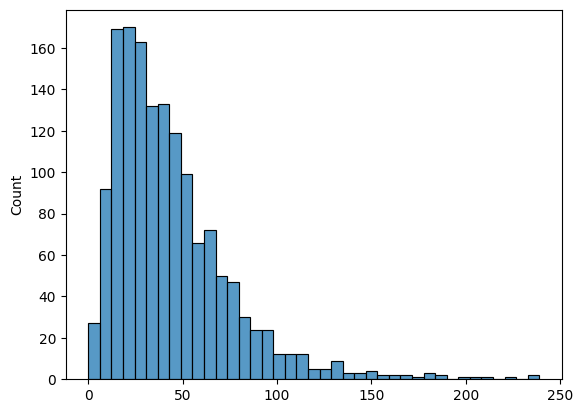

In [ ]:
length = [len(i) for i in X_train]
print("The Average Review length in the training set is ", np.mean(length))
print("The Max Review length is", np.max(length))
print("The Standard Deviation is", round(np.std(length)))

sns.histplot(length)
plt.show()

<Axes: xlabel='rating', ylabel='count'>

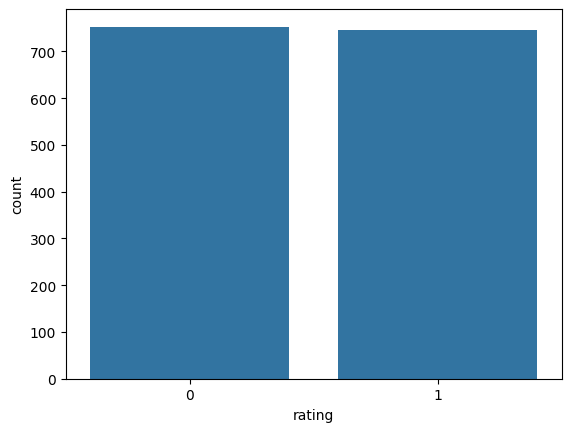

In [ ]:
# Show that training set is well-balanced between positive & negative reviews
sns.countplot(x=y_train)

# B3. Padding

In [ ]:
vocab_size = len(t.word_index)
# Set max length to be 2 SDs above mean length
maxlen = round(np.mean(length) + 2 * (np.std(length)))
print(maxlen)

107


In [ ]:
# Code ref: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)
val_pad = pad_sequences(val_seq, padding='post', maxlen=maxlen)


print("\n",val_text[0])
print(val_seq[0],"\n")
val_pad[0]


 no way plug u unless go converter
[20, 24, 1305, 49, 1037, 16, 1] 



array([  20,   24, 1305,   49, 1037,   16,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
train_labels = y_train.to_numpy().flatten()
test_labels = y_test.to_numpy().flatten()
val_labels = valy.to_numpy().flatten()

print(X_train_pad.T.shape)
print(train_labels.T.shape)
train_out_ary = np.hstack((np.atleast_2d(train_labels).T, X_train_pad))
test_out_ary = np.hstack((np.atleast_2d(test_labels).T, X_test_pad))
val_out_ary = np.hstack((np.atleast_2d(val_labels).T, val_pad))

columns=["Labels"]
columns = columns + ["seq_" + str(i) for i in range(1,val_out_ary.shape[1])]

df_train_out = pd.DataFrame(train_out_ary, columns=columns)
df_test_out = pd.DataFrame(test_out_ary, columns=columns)
df_val_out = pd.DataFrame(val_out_ary, columns=columns)
df_train_out.to_csv('traindata_pad.csv', index=False)
df_test_out.to_csv('testdata_pad.csv', index=False)
df_val_out.to_csv('valdata_pad.csv', index=False)


(107, 1500)
(1500,)


# Part III - Model creation and fit

In [ ]:
# Word embedding length - code ref: Ellis, D213 Task 2 Cohort PPT
max_seq_embedding = int(round(np.sqrt(np.sqrt(vocab_size)),0))
print(max_seq_embedding)

In [ ]:
# Code ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# Code ref: https://www.tensorflow.org/text/tutorials/text_classification_rnn
# Code ref: https://campus.datacamp.com/courses/introduction-to-deep-learning-in-python/fine-tuning-keras-models?ex=6

# Initialize random seed, enable deterministic mode

tf.keras.utils.set_random_seed(4877)
tf.config.experimental.enable_op_determinism()

# Build the model
model = tf.keras.Sequential([
    Embedding(vocab_size, max_seq_embedding, input_length=maxlen),
    #Flatten(),
    #Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    #Dense(128, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
opt = 'adam'
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

history = model.fit(X_train_pad, train_labels, validation_data=(X_test_pad, test_labels), epochs = 100, callbacks=[early_stopping_monitor])

model.summary()

# D3. Training Process Visualizations

In [ ]:
# code ref: https://www.tensorflow.org/text/tutorials/text_classification_rnn
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()



# D4. Predictive Accuracy

In [ ]:
scores = model.evaluate(X_test_pad, test_labels)
print("Accuracy on Test Set: %.2f%%" % (scores[1]*100))

scores = model.evaluate(val_pad, val_labels)
print("Accuracy on Amazon Data: %.2f%%" % (scores[1]*100))

# Get predicted labels
# Code ref: https://www.freecodecamp.org/news/binary-classification-made-simple-with-tensorflow/
y_pred = tf.squeeze(model.predict(val_pad))
predicted = np.array([1 if x >= 0.5 else 0 for x in y_pred])

# Create confusion matrix
cm = confusion_matrix(val_labels, predicted)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Amazon Dataset")
plt.show()


# E. Model save

In [ ]:
# Save model
model.save('sent_analysis.keras')